# Week 2 Assignment: K-Means Clustering

## Student: Sneha Santha Prabakar

## Submission: 16-April-2025

# Step 1: Import libraries and data

In [406]:
import pandas as pd
import numpy as np
import itertools
from random import sample
from numpy.random import uniform
from math import isnan

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

In [407]:
df = pd.read_csv('customer_data.csv')
df.head()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Purchase Frequency,Avg Purchase Value
0,1,56,84,71.905329,5.9,106.071893
1,2,69,86,38.482533,6.0,62.755253
2,3,46,41,38.967487,7.5,29.958887
3,4,32,23,10.002036,1.7,67.007220
4,5,60,76,56.350309,2.9,72.704110


In [408]:
# Size of the dataframe
df.shape

(200, 6)

In [409]:
# View the data type of all features
df.dtypes

CustomerID                  int64
Age                         int64
Annual Income (k$)          int64
Spending Score (1-100)    float64
Purchase Frequency        float64
Avg Purchase Value        float64
dtype: object

We see that there are 200 rows and 6 columns, and all these columns are numeric (either int or float). 

The CustomerID is a unique identifier column. The remaining columns showcase the features of each customer.

Some points to note:
- The unit of annual income is in thousands of dollars
- The Spending Score has a fixed range between 1 - 100

We can now explore the statistics of these numeric features.

In [410]:
# Get an overview of the statistics of the numeric features
# Note: We are dropping the CustomerID column here as it is a unique identifier, not a descriptive variable
df.drop(columns='CustomerID').describe()

,Age,Annual Income (k$),Spending Score (1-100),Purchase Frequency,Avg Purchase Value
count,200.00000,200.000000,200.000000,200.000000,200.000000
mean,43.42500,67.145000,50.869302,5.335500,43.092021
std,14.94191,31.249587,22.563855,2.687808,29.326249
min,18.00000,15.000000,1.000000,0.600000,10.000000
25%,31.00000,41.000000,32.366332,3.000000,17.651673
50%,43.50000,66.500000,52.352457,5.450000,36.086311
75%,56.00000,95.250000,67.224241,7.600000,59.641832
max,69.00000,119.000000,100.000000,10.000000,137.621150


In [411]:
# Check for missing values in each column
df.isna().sum()

CustomerID                0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
Purchase Frequency        0
Avg Purchase Value        0
dtype: int64

From the preliminary analysis, we can see make the following observations:
1. There is **no missing data** in any column.
2. **Age** of the customers is in the range: 18 - 69. This shows that the data includes customers from young adults to senior citizens. This allows for age-related behavioral segmentation. The median (43.5) is almost the same as the mean (43.4), which shows that there is a uniform distribution of all age groups in the dataset.
3. The **annual income** of the customer spans a wide range (15k - 119k). This may influence the customers purchasing power. The median (66.5) is close to the mean (67.1), so its not heavily skewed distribution.
4. **Spending score** is also widely distributed (1-100), suggesting the presence of both frugal and generous spenders. The Median (52.35) is close to the mean (50.8), so its not heavily skewed distribution.
5. **Purchase Frequency** also has a wide range (1-10) but uniformly distributed, since the median (5.45) is close to the mean (5.33). It suggests that some customers shop frequently whereas other shop rarely.
6. The **Avg Purchase Value** ranges from 10-137, with a slightly right-skewed distribution as the median (36) is lower than the mean (43). The 75% percentile is 59.6, while the max is 137.6 - this may suggest that while most customers spend modestly, there are some outliers which push the mean higher.

# Step 2: Data Visualisation and Enhancement

## 2.1. Exploratory Data Analysis (EDA)

We first need to understand the distribution of individual variables and the relationship between the variables.

To do this, we can either:
- Individually plot 5 distribution histograms (for each variable) + 8 scatterplots (for relationship between each pair of variables), or
- Use the Seaborn library's pairplot function to visualize the distrbution chars and the scatterplots between all the variables more neatly, within one frame.

In the code snippets below, I have **included codes for both methods**. 

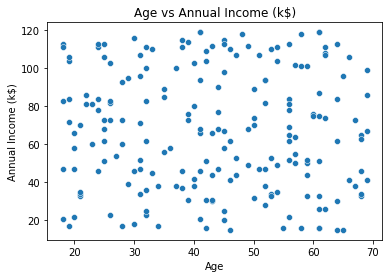

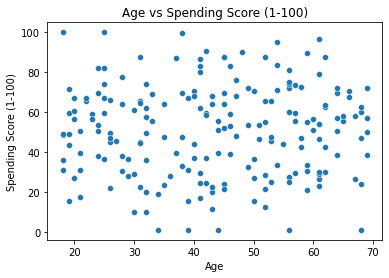

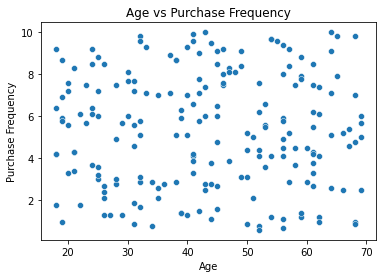

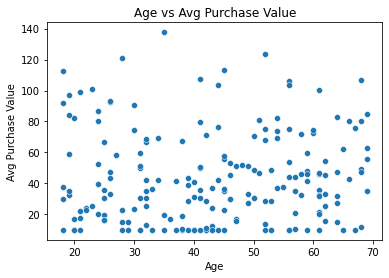

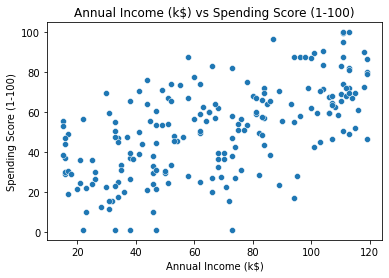

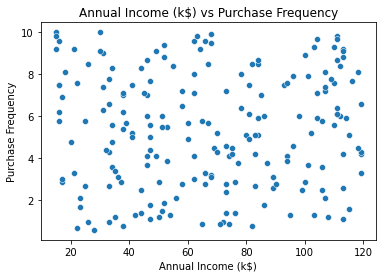

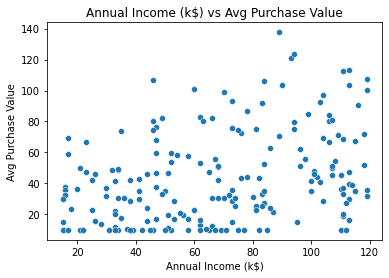

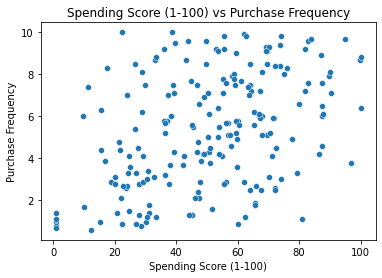

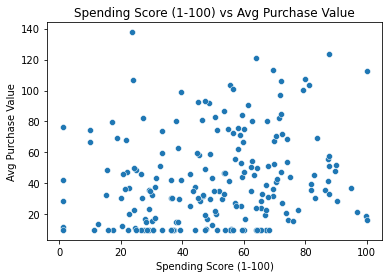

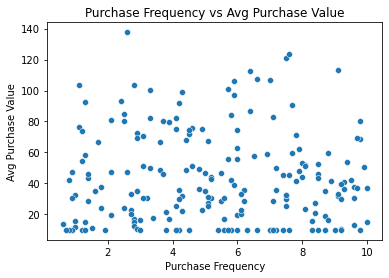

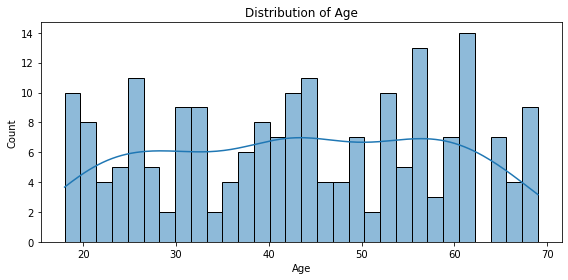

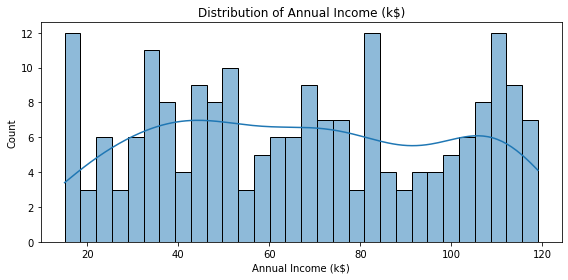

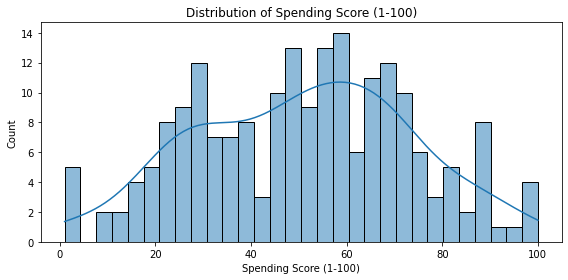

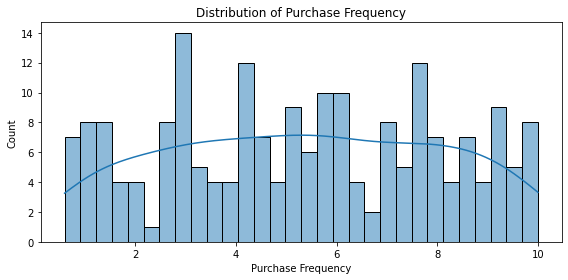

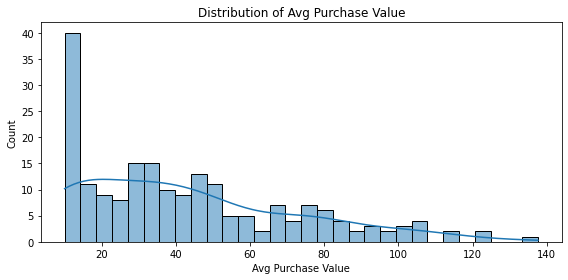

In [412]:
# Method 1: Individually plot 5 distribution histograms (for each variable) + 
# 8 scatterplots (for relationship between each pair of variables)

features_df = df.drop(columns=['CustomerID'])
features_ls = features_df.columns.tolist()

# Scatterplots - for relationship between each pair of variables

features_cmb = list(itertools.combinations(features_ls, 2))

for x_var, y_var in features_cmb:
    sns.scatterplot(x=x_var, y=y_var, data=df)
    plt.title(f'{x_var} vs {y_var}')
    plt.show()

# Distribution charts - for individual variables
for col in features_df.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

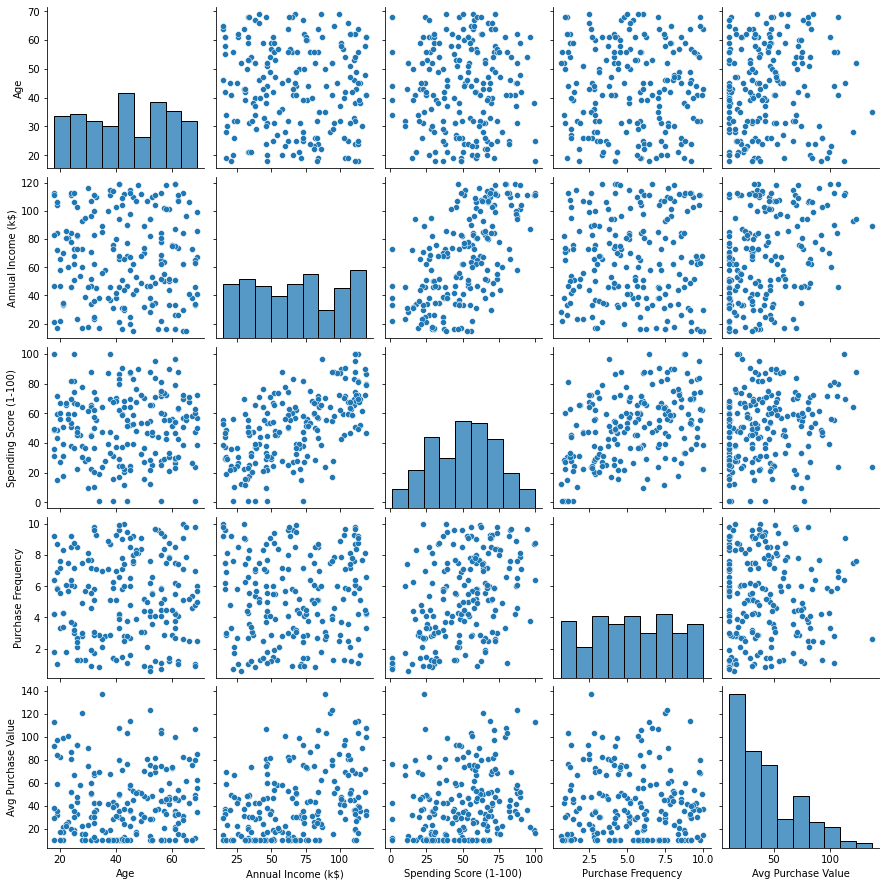

In [413]:
# Method 2: Using Seaborn's pairplot function for cleaner visualization

features_df = df.drop(columns=['CustomerID'])
sns.pairplot(features_df)
plt.show()

We can make the following observations about the individual distribution of the variables and the relationship between the variables:

- Individual distribution:
    - Age and Annual income: Roughly uniform distribution. 
    - Spending score: Faily normal distribution since it is bell-shaped.
    - Purchase frequency: Looks relatively even, possibly slightly skewed towards more frequent shoppers.
    - Avg purchase value: Right-skewed which suggests that most customers make smaller-value purchases. The high-spenders are a minority (some may even be outliers).

- Relationship between the variables:
    - Most scatterplots show no strong correlation between the variables. 
    - The only variables that show a *slightly* **positive** correlation are:
        - Spending Score vs Annual Income
        - Spending Score vs Purchase Frequency
        - Avg Purchase Value vs Annual Income

**Correlation heatmap to understand feature relationships**

We already know that all the features are numeric, hence we don't need to add a filter for numeric columns.
However, we need to remove CustomerID column as it is only an identifier, not a descriptive variable.

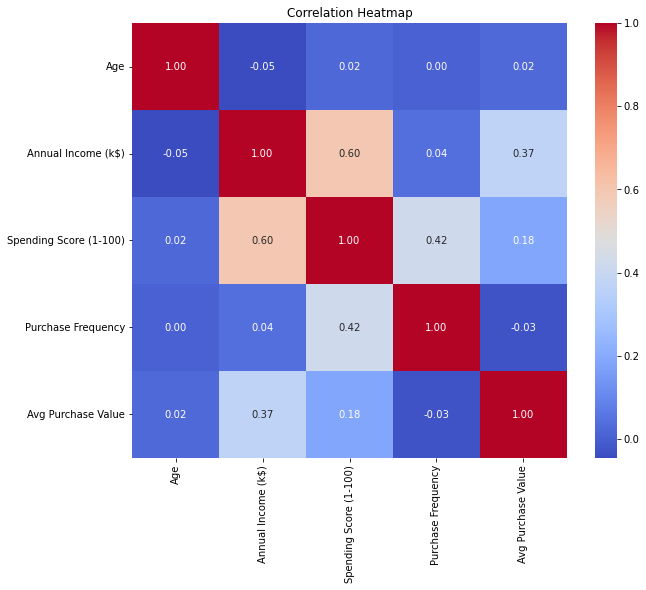

In [414]:
df_numeric = df.drop(columns=['CustomerID'])
corr_matrix = df_numeric.corr()


plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt="0.2f", square=True)
plt.title("Correlation Heatmap")
plt.show()

This heatmap confirms that most of the variables not linearly correlated, except Annual income and Spending score. The correlation coefficient between Annual Income and Spending score is 0.6 which is greater than 0.5, which suggests a slightly positive correlation between the two (which was also observed on the Scatterplots above). However, it is still not strong enough to indicate a positive dependency as it is lesser than 0.75. 

Hence, we can  conclude that the variables are not linearly correlated to each other.

## 2.2. Check for missing values and outlier

**Identify and handle missing data**

In [415]:
df.isna().sum()

CustomerID                0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
Purchase Frequency        0
Avg Purchase Value        0
dtype: int64

There are no missing values in the data.

**Detect outliers using box plots**

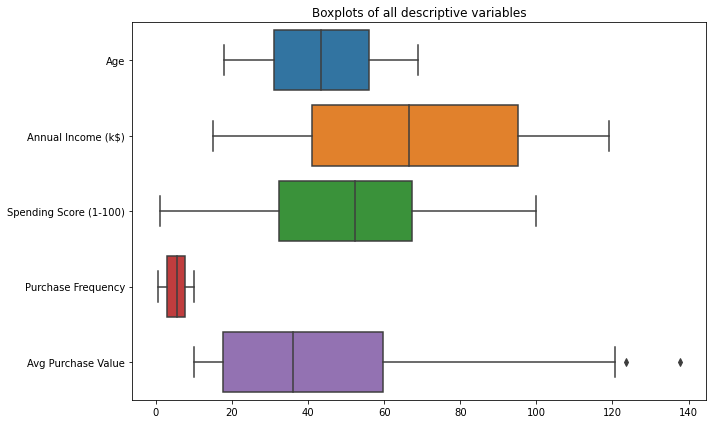

In [416]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=features_df, orient='h')
plt.title('Boxplots of all descriptive variables')
plt.tight_layout()
plt.show()

In [417]:
# Identify the records that are the outliers

Q1 = df['Avg Purchase Value'].quantile(0.25)
Q3 = df['Avg Purchase Value'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'Lower bound of Avg Purchase Value is {round(lower_bound, 2)} and the Upper bound of Avg Purchase Value is {round(upper_bound,2)}\n')

outliers = df[(df['Avg Purchase Value'] < lower_bound) | (df['Avg Purchase Value'] > upper_bound)]
outliers

Lower bound of Avg Purchase Value is -45.33 and the Upper bound of Avg Purchase Value is 122.63



,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Purchase Frequency,Avg Purchase Value
47,48,35,89,23.631195,2.6,137.621150
132,133,52,94,87.592673,7.6,123.466386


The outlier values for Avg Purchase value: 
- 137.6 is only approximately 1.1x more than the upper bound 
- 123.4 is very close to the upper bound

This tells us that:
1. These outlier values are valid, since they are not largely off the charts
2. Since they are not too far from the upper bound (for the reasons stated above), they most probably won't influence the creation of K means clusters much.

CustomerID 48 has the highest Avg Purchase Value, though his purchase frequency is relatively low (2.6 on a scale of 10), his Annual Income is in the third quartile, and his spending score is also relatively low (23.6 on a scale of 100). 

CustomerID 133 shows a relatively high annual income, spending score, purchase frequency and close to normal Avg Purchase value (i.e. close to the upper bound).

Let us see if removing CustomerID 48 significantly impacts the mean/median/std deviation of the Avg Purchase Value column:

In [418]:
df['Avg Purchase Value'].describe()

count    200.000000
mean      43.092021
std       29.326249
min       10.000000
25%       17.651673
50%       36.086311
75%       59.641832
max      137.621150
Name: Avg Purchase Value, dtype: float64

In [419]:
tmp_df = df[df['CustomerID'] != 48]
tmp_df['Avg Purchase Value'].describe()

count    199.000000
mean      42.617000
std       28.618448
min       10.000000
25%       17.524458
50%       35.863952
75%       59.328312
max      123.466386
Name: Avg Purchase Value, dtype: float64

We can see that removing CustomerID 48 does not really have a major impact on the mean/median/std deviation of the Avg Purchase Value column. Since CustomerID 133 has an even lower Avg Purchase Value than CustomerID 48, it is unlikely that removing CustomerID 133 is also going to have any significant impact on the column.

Hence, we will simply retain these two rows seeing that they do not siginficantly impact the distribution of Avg Purchase Value.

## 2.3. Scaling the features

We need to standardize the features to make sure the clustering algorithm is not biased (since it is a distance-based algorithm). We choose standardization over normalization because (1) our variables differ in range (2) most of them are normally/uniformly distributed (3) we want to retain the outlier influence, if any.

In [420]:
# Extracting the numeric features (i.e. excluding the CustomerID column as it is just an identifier)
features_df = df.drop(columns=['CustomerID'])

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(features_df)

# Convert back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=features_df.columns)

X_scaled_df.head()

,Age,Annual Income (k$),Spending Score (1-100),Purchase Frequency,Avg Purchase Value
0,0.843704,0.540721,0.934628,0.210549,2.152949
1,1.715924,0.604882,-0.550343,0.247848,0.672182
2,0.172767,-0.838751,-0.528796,0.807324,-0.448952
3,-0.766547,-1.416204,-1.815728,-1.355983,0.817534
4,1.112080,0.284075,0.243521,-0.908403,1.012281


## 2.4. Transformed data summary

In [421]:
X_scaled_df.describe()

,Age,Annual Income (k$),Spending Score (1-100),Purchase Frequency,Avg Purchase Value
count,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02
mean,1.859624e-16,1.199041e-16,3.080869e-17,1.247613e-16,-8.215650e-17
std,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00
min,-1.705860e+00,-1.672849e+00,-2.215687e+00,-1.766266e+00,-1.131241e+00
25%,-8.336404e-01,-8.387506e-01,-8.220848e-01,-8.711042e-01,-8.696710e-01
50%,5.032034e-03,-2.069207e-02,6.589641e-02,4.270667e-02,-2.394882e-01
75%,8.437044e-01,9.016288e-01,7.266480e-01,8.446223e-01,5.657506e-01
max,1.715924e+00,1.663546e+00,2.182871e+00,1.739784e+00,3.231451e+00


Here, we can see that after scaling, the mean of all the variables is approx 0, and the standard deviation is also approx 1. 

# Step 3. Determine the optimal number of clusters

## 3.1. Elbow Test

In [422]:
inertias = []
K_range = range(1, 10)  

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled_df)
    inertias.append(kmeans.inertia_)

In [440]:
print("K vs. Interia")
list(zip(range(2,10),inertias))

K vs. Interia


[(2, 1000.0),
 (3, 726.2497355567082),
 (4, 615.1969120596842),
 (5, 524.5907761557905),
 (6, 457.2234557865531),
 (7, 414.39382038796043),
 (8, 381.0053268174217),
 (9, 352.0087299083099)]

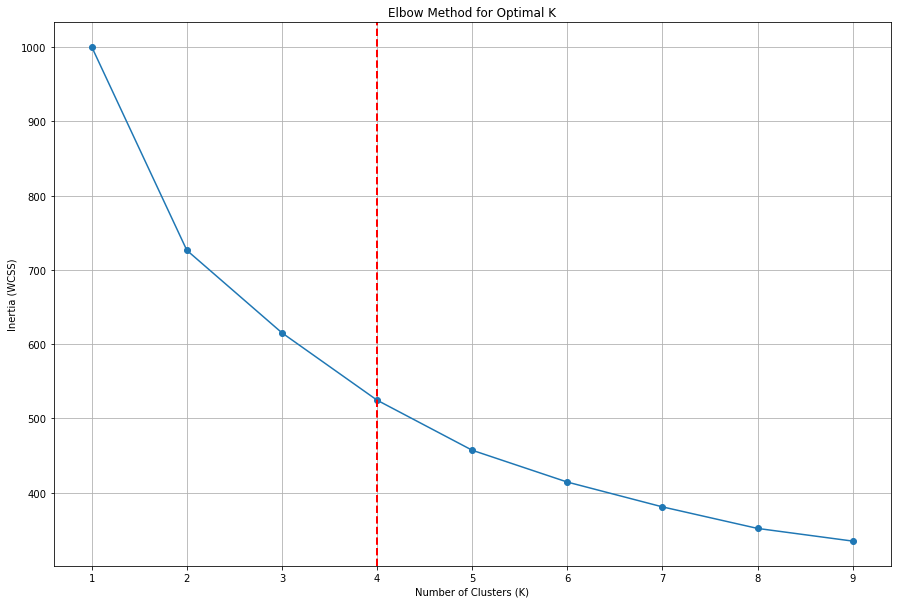

In [424]:
plt.figure(figsize=(15, 10))
plt.plot(K_range, inertias, marker='o')
plt.axvline(x=4, color='red', linestyle='--', linewidth=2, label='Elbow at K=4')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)
plt.show()

By visual inspection, we can see that the elbow is at K = 4. Hence the optimal K (by Elbow method) is 4.

## 3.2. Silhouette Score

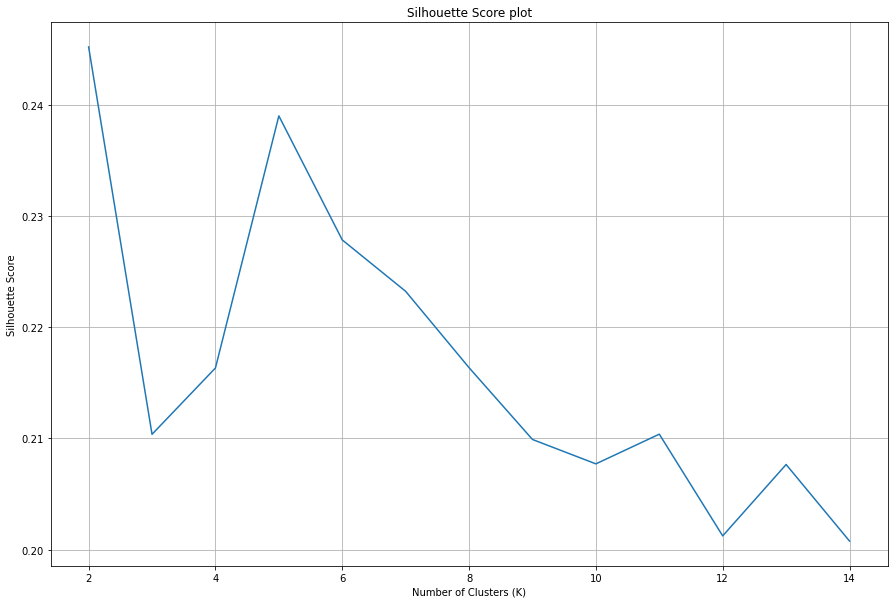

In [425]:
silhouette_scores = []
for k in range(2,15):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_scaled_df)
    silhouette_scores.append([k, silhouette_score(X_scaled_df, kmeans.labels_)])

sse_df = pd.DataFrame(silhouette_scores)

plt.figure(figsize=(15, 10))
plt.plot(sse_df[0], sse_df[1])
plt.title('Silhouette Score plot')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [426]:
sse_df.rename(columns={0:"K", 1:"SSE"}, inplace=True)
sse_df.set_index(sse_df.columns[0], inplace=True)
sse_df

,SSE
K,
2,0.245193
3,0.210367
4,0.216329
5,0.238990
6,0.227841
7,0.223219
8,0.216355
9,0.209901
10,0.207709


The Silhouette score peak is at K = 5. Hence, the optimal K (by Silhouette method) is 5.

We see that the optimal K determined by both the methods are very close. The Elbow method focuses on the compactness within each cluster whereas the Silhouette score focuses on the seperation and cohesion of the clusters.

We can choose K = 5, since the clusters are better seperated at this point (as suggested by Silhouette score) and it still has good elbow. 

# Step 4. Implement K Means Cluster

## 4.1. Train K-Means Model and assign Cluster labels to Customers

In [427]:
# Initialise and train the K-Means model with the optimal k value and assign cluster labels to each customer

np.random.seed(1)
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled_df)

df['Cluster'] = cluster_labels

In [428]:
df.head()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Purchase Frequency,Avg Purchase Value,Cluster
0,1,56,84,71.905329,5.9,106.071893,4
1,2,69,86,38.482533,6.0,62.755253,4
2,3,46,41,38.967487,7.5,29.958887,3
3,4,32,23,10.002036,1.7,67.007220,1
4,5,60,76,56.350309,2.9,72.704110,4


## 4.2. Cluster visualisation - PCA and t-SNE

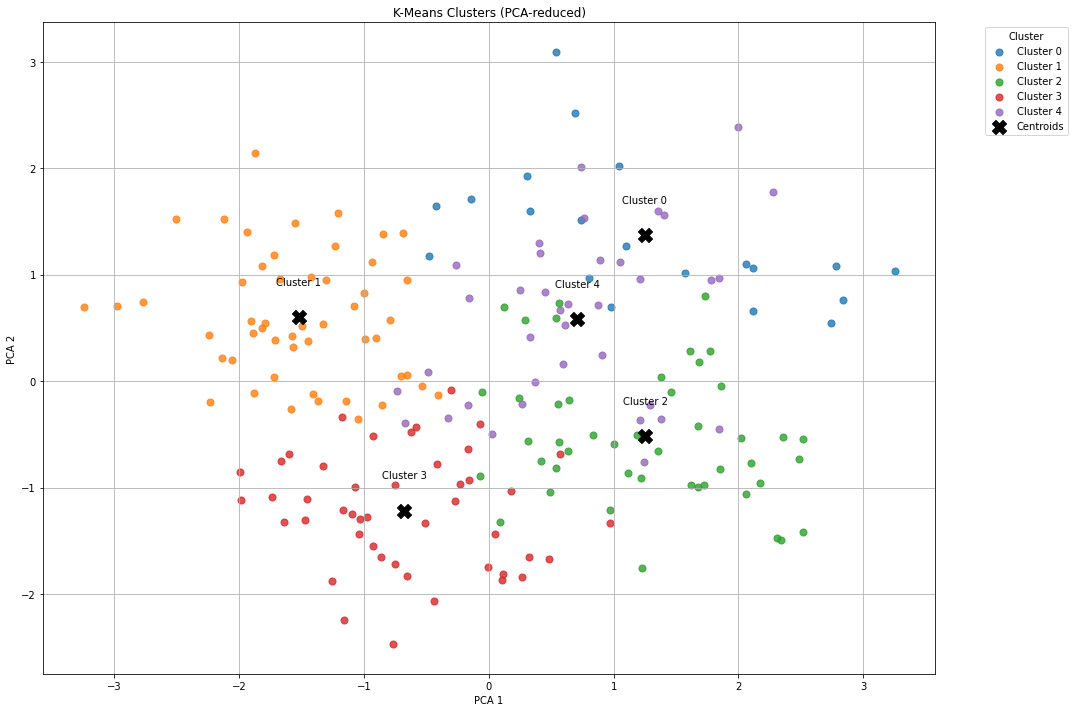

In [429]:
plt.figure(figsize=(15, 10))

# Loop through each cluster to plot individually (for legend)
for cluster in np.unique(cluster_labels):
    plt.scatter(
        pca_components[cluster_labels == cluster, 0],
        pca_components[cluster_labels == cluster, 1],
        label=f'Cluster {cluster}',
        s=50,
        alpha=0.8
    )

# Add cluster centroids
plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    c='black', s=200, marker='X', label='Centroids'
)

# Annotate centroid labels
for i, (x, y) in enumerate(centroids_pca):
    plt.text(x, y + 0.3, f'Cluster {i}', color='black', ha='center', fontsize=10)

# Legend (side)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('K-Means Clusters (PCA-reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.tight_layout()
plt.show()


In this 2D PCA space, we can see that:
- The clusters are mostly well-seperated with some overlaps.
- The centroids (marked as red X on the plot) are visibly distinct and not tightly packed - this implies that K-means algorithm found meaningful partitions in the data.

/Users/snehaprabakar/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  >>> import numpy as np


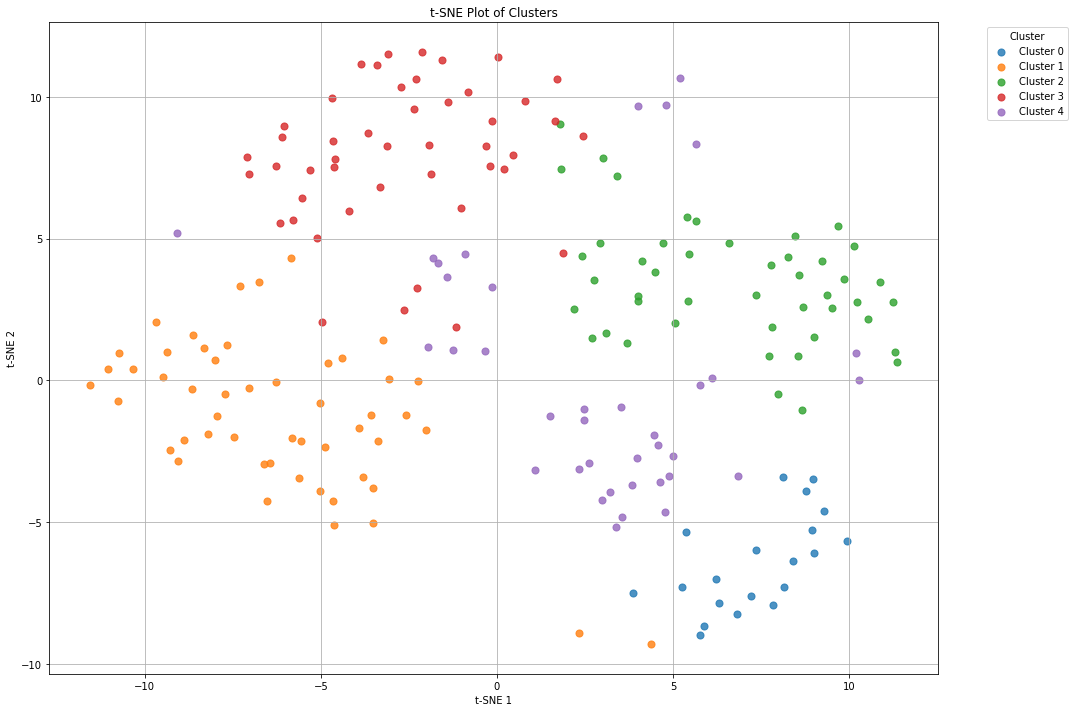

In [430]:
# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled_df)

# Plot
plt.figure(figsize=(15, 10))

# Loop through each cluster
for cluster in np.unique(cluster_labels):
    plt.scatter(
        X_tsne[cluster_labels == cluster, 0],
        X_tsne[cluster_labels == cluster, 1],
        label=f'Cluster {cluster}',
        s=50,
        alpha=0.8
    )

plt.title('t-SNE Plot of Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')  # Side legend
plt.tight_layout()
plt.show()

- The clusters are very well-separated with sharper boundaries in the t-SNE plot than in the PCA plot.
- There is still some overlap between the clusters, but the cluster cohesion is visually stronger here.



Overall, both PCA and t-SNE plots confirm that the K-Means algorithm successfully grouped the customers into 5 distinct clusters.

## 4.3. Cluster Visualisation - 2D plots

We have 5 features in total. We will now visualize the scatter plots of the clusters across different pairs of features.

In [431]:
df.head()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Purchase Frequency,Avg Purchase Value,Cluster
0,1,56,84,71.905329,5.9,106.071893,4
1,2,69,86,38.482533,6.0,62.755253,4
2,3,46,41,38.967487,7.5,29.958887,3
3,4,32,23,10.002036,1.7,67.007220,1
4,5,60,76,56.350309,2.9,72.704110,4


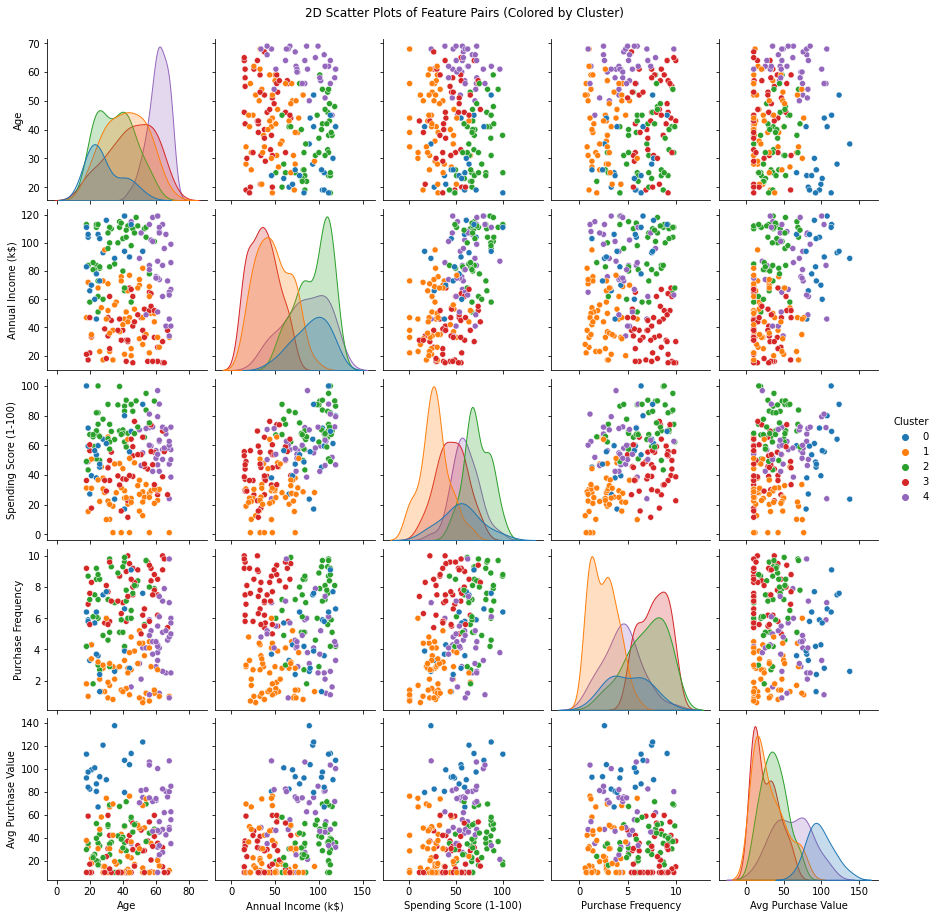

In [432]:
sns.pairplot(df, vars=df.columns[1:6], hue='Cluster', palette='tab10')
plt.suptitle("2D Scatter Plots of Feature Pairs (Colored by Cluster)", y=1.02)
plt.show()

The pairwise features that show better seperation between the clusters are:
1. Annual Income vs Spending Score
2. Purchase Frequency vs Avg Purchase Value
3. Spending Score vs Purchase Frequency	

### Showcased below are the 2D plots of these pairwise features

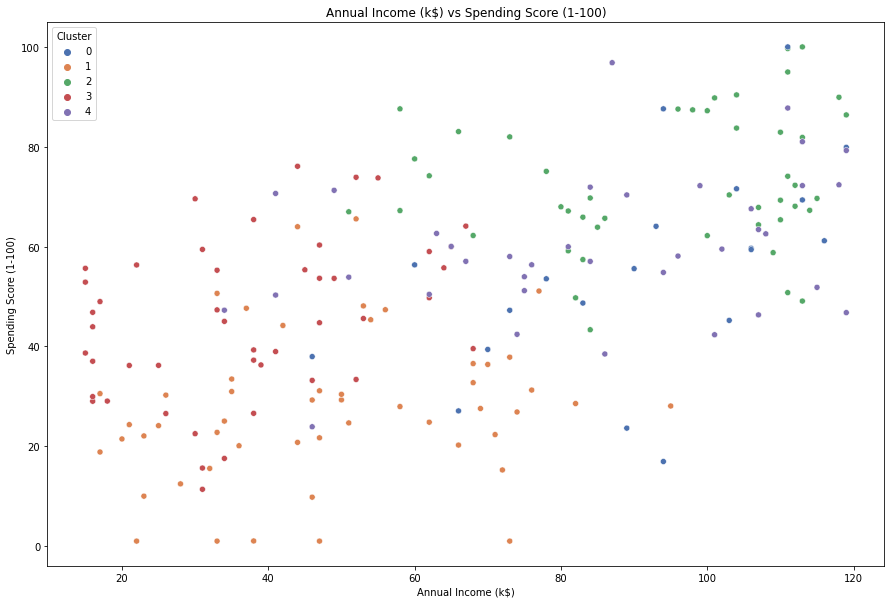

In [433]:
plt.figure(figsize=(15, 10))

x_var = 'Annual Income (k$)'
y_var = 'Spending Score (1-100)'
sns.scatterplot(x=x_var, y=y_var, data=df, hue='Cluster', palette="deep", legend="full")
plt.title(f'{x_var} vs {y_var}')
plt.show()

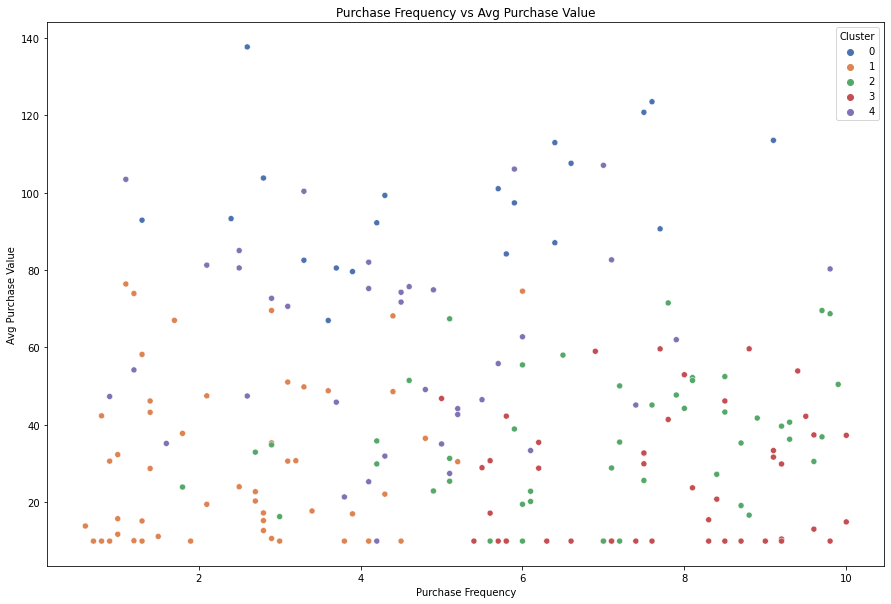

In [434]:
plt.figure(figsize=(15, 10))

x_var = 'Purchase Frequency'
y_var = 'Avg Purchase Value'
sns.scatterplot(x=x_var, y=y_var, data=df, hue='Cluster', palette="deep", legend="full")
plt.title(f'{x_var} vs {y_var}')
plt.show()

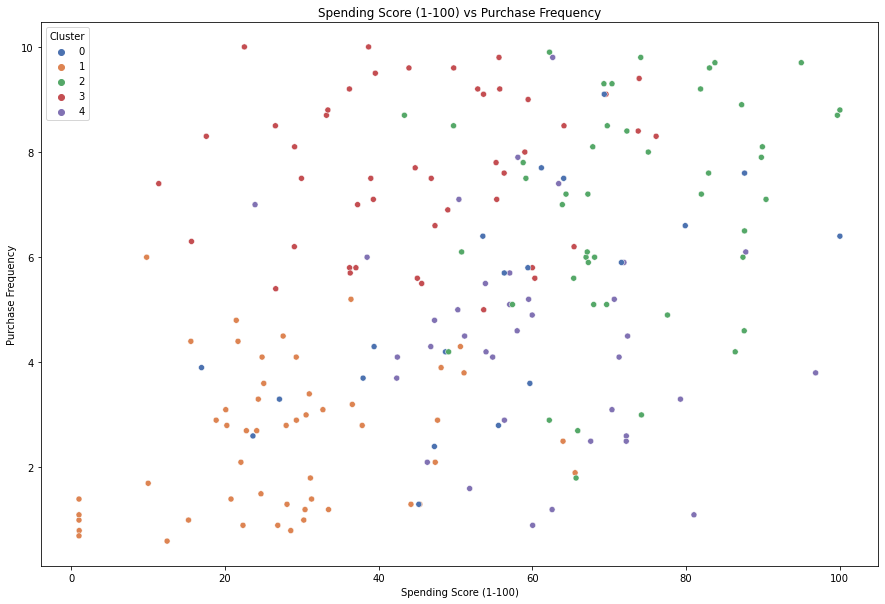

In [435]:
plt.figure(figsize=(15, 10))

x_var = 'Spending Score (1-100)'
y_var = 'Purchase Frequency'
sns.scatterplot(x=x_var, y=y_var, data=df, hue='Cluster', palette="deep", legend="full")
plt.title(f'{x_var} vs {y_var}')
plt.show()

We can also look at how much the average value of each feature differs across clusters. This helps us identify which features contribute the most to distinguishing one customer group from another.

In [436]:
df.drop(columns=['CustomerID']).groupby('Cluster').mean()

,Age,Annual Income (k$),Spending Score (1-100),Purchase Frequency,Avg Purchase Value
Cluster,,,,,
0,28.950000,90.700000,55.214181,5.040000,98.350281
1,41.647059,48.058824,27.535763,2.501961,30.122700
2,35.652174,94.239130,72.976458,6.945652,36.720253
3,45.043478,36.913043,45.357979,7.715217,25.633661
4,61.351351,84.621622,60.050506,4.440541,60.725968


Based on the scatterplot visualization and the means table, we can conclude that the following features are the top 3 key variables for customer segmentation:

- Annual Income:
    - Shows strong variation across the clusters and distinguishes them based on the income level.
    - Going by the mean of Annual income in each cluster, we can say that:
        - Cluster 0 and 2: High-income group (Cluster 2 is the highest income group with mean=94.2)
        - Cluster 4: Medium-income group
        - Cluster 1 and 3: Low-income group (Cluster 3 is the lowest income group with mean=36.9)
- Spending Score:
    - Helps differentiate engagement levels. 
    - Going by the mean of Spending score in each cluster, we can say that:
        - Cluster 2 and 4: High-spending group (Cluster 2 has the highest spending with mean=72.9)
        - Cluster 0 and 3: Medium-spending group
        - Cluster 1: Low-spending group (mean=27.5)
- Avg Purchase Value:
    - Differentiates between premium and budget-concious customers.
    - Going by the mean of the Avg Purchase Value, we can say that:
        - Cluster 0: High-spending per transaction (mean=98.35)
        - Cluster 4: Medium-spending per transaction (mean=60.7)
        - Cluster 1,2 and 3: Low-spending (budget) per transaction (Cluster 3 having the most budget-concious customers, with mean=25.6)

## 4.4. Cluster Visualisation - 3D plots

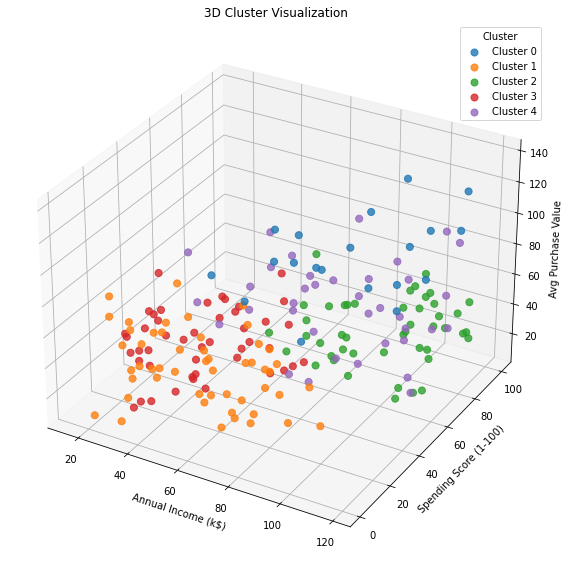

In [437]:
# Set up the 3D figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in np.unique(df['Cluster']):
    clustered_data = df[df['Cluster'] == cluster]
    ax.scatter(
        clustered_data['Annual Income (k$)'],
        clustered_data['Spending Score (1-100)'],
        clustered_data['Avg Purchase Value'],
        label=f'Cluster {cluster}',
        s=50,
        alpha=0.8
    )

ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Spending Score (1-100)')
ax.set_zlabel('Avg Purchase Value')
ax.set_title('3D Cluster Visualization')

ax.legend(title='Cluster')
plt.tight_layout()
plt.show()


The clusters seem to be more distinct in high-value and low-value groups, while there are some overlaps in the mid-value groups. 

# Step 5. Interpret the characteristics of each cluster

In [441]:
print("Distribution of the Mean of each feature across the clusters")
df[['Cluster', 'Annual Income (k$)', 'Spending Score (1-100)', 'Avg Purchase Value']].groupby('Cluster').mean()

Distribution of the Mean of each feature across the clusters


,Annual Income (k$),Spending Score (1-100),Avg Purchase Value
Cluster,,,
0,90.700000,55.214181,98.350281
1,48.058824,27.535763,30.122700
2,94.239130,72.976458,36.720253
3,36.913043,45.357979,25.633661
4,84.621622,60.050506,60.725968


We can make the following obervations about the customer segmentation:

- Cluster 0: High-income, high-spending per transaction. Likely loyal, premium buyers.
- Cluster 1: Medium-income, low spenders on all fronts. Likely price-sensitive or low engagement customers.
- Cluster 2: Very wealthy & active spenders. Strong candidates for elite targeting.
- Cluster 3: Lower income, moderate behavior. Baseline customers.
- Cluster 4: Upper-mid income, moderately engaged. Responsive to smart promotions.
